<h1><center>DSA 4212: Year 2018-2019</center></h1>
<h3><center> Assignment 1 (Deadline: Friday 29th of March, 23:59, To Be submitted on the IVLE )</center></h3>







In [0]:
from __future__ import division, print_function
from builtins import range

%matplotlib inline
import autograd.numpy as np
from autograd import grad
np.random.seed(123)
import time as time
import matplotlib.pyplot as plt


# Data Dowload
1. Download the "img_align_celeba.zip" file available at: 
https://bit.ly/2VGi7MT
This is a 1.34GB large zip-file containing 200K face images.
2. Download the attribute file "list_attr_celeba.txt" available at:
https://bit.ly/2XwVbkR
3. After downloading the file "list_attr_celeba.txt", open it with your favorite text editor and delete the first line. This first line to be deleted contains only a single number "202599" and is not useful to us.
4. Unzip the file "img_align_celeba.zip" in the directory of your choice. (Data = 1.78 GB when uncompressed). 


# Loading the data
1. We will try to build a very simple model that can automatically find the gender of a face.
2. First, we will create a list of all the images and load all the gender attributes

In [0]:
import os as os
import pandas as pd  #install the packages "pandas" if not already done so. 

#read the filenames of all the images
path_to_img = "/Users/alex/Dataset/celebA/img_align_celeba"
jpgfiles = [file for file in os.listdir(path_to_img) if os.path.isfile(os.path.join(path_to_img, file)) and file.lower().endswith('.jpg')]
total_img = len(jpgfiles)
print("Number of images = ", total_img)

#load all the attributes
data_frame = pd.read_csv('/Users/alex/Dataset/celebA/list_attr_celeba.txt', delim_whitespace=True)
data_gender = data_frame.Male.values
print("Number of attributes loaded = ", len(data_gender))

Number of images =  202599
Number of attributes loaded =  202599


In [0]:
jpgfiles[0]

'000001.jpg'

# Sanity checks
For simplicity, we will only consider grayscale images. To this end, let us first create a function that takes an image index as input, reads the corresponding image and transform it into a grayscale image. Then, for sanity check, we will display the first few images/genders to make sure that everything is in order.

In [0]:
#Install the Pillow library if necessary (https://pillow.readthedocs.io/en/latest/installation.html)
from PIL import Image  

def read_image(path, file_index):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, jpgfiles[file_index])))
    return np.mean(img, axis=2) / 255.

The images have dimensions: 218 x 178
Total number of pixels: 38804


(-0.5, 177.5, 217.5, -0.5)

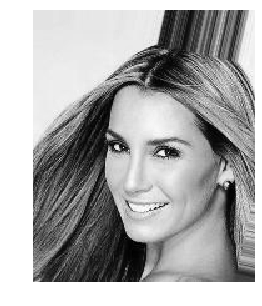

In [0]:
#display the first image
plt.rcParams['figure.figsize'] = (5,5)
img = read_image(path_to_img, 0)
dim_x, dim_y = img.shape
print("The images have dimensions:", dim_x, "x", dim_y)
print("Total number of pixels:", dim_x*dim_y)
plt.imshow(img, cmap="gray")
plt.axis("off")

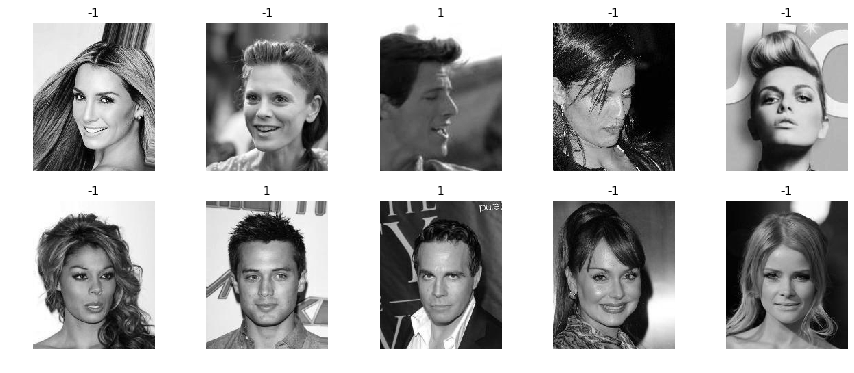

In [0]:
#let us display a few faces/gender
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img, img_index)
        gender = data_gender[img_index]
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.title(gender)
        plt.axis('off')
        

(-0.5, 177.5, 217.5, -0.5)

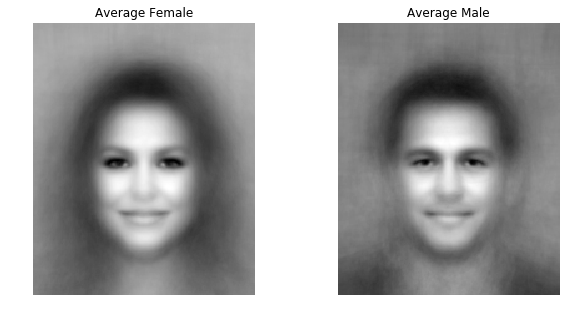

In [0]:
#for fun, let us display the average of the first 500 male/female
nb_faces_to_avrg = 500
avrg_face_male = np.zeros((dim_x, dim_y))
avrg_face_female = np.zeros((dim_x, dim_y))

nb_male, nb_female, img_index = 0, 0, 0 
while (nb_male < nb_faces_to_avrg) and (nb_female < nb_faces_to_avrg):
    img = read_image(path_to_img, img_index)
    gender = data_gender[img_index]
    if gender == -1:
        avrg_face_female += img
        nb_female += 1
    else:
        avrg_face_male += img
        nb_male += 1
    img_index += 1

avrg_face_male = avrg_face_male / float(nb_faces_to_avrg)
avrg_face_female = avrg_face_female / float(nb_faces_to_avrg)

plt.rcParams['figure.figsize'] = (5*2,5) # Make the figures a bit bigger
plt.subplot(1,2,1)
plt.imshow(avrg_face_female, cmap="gray")
plt.title("Average Female")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(avrg_face_male, cmap="gray")
plt.title("Average Male")
plt.axis("off")

Now, we would also like to see what the accuracy of the same approach is when the eyes of a person are not displayed. To this end, we also define the function "read_image_without_eyes" to read an image and hide the eyes

In [0]:
def read_image_without_eyes(path, file_index):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, jpgfiles[file_index])))
    img_black_n_white = np.mean(img, axis=2) / 255.
    img_black_n_white[100:130,50:130] = 0
    return img_black_n_white

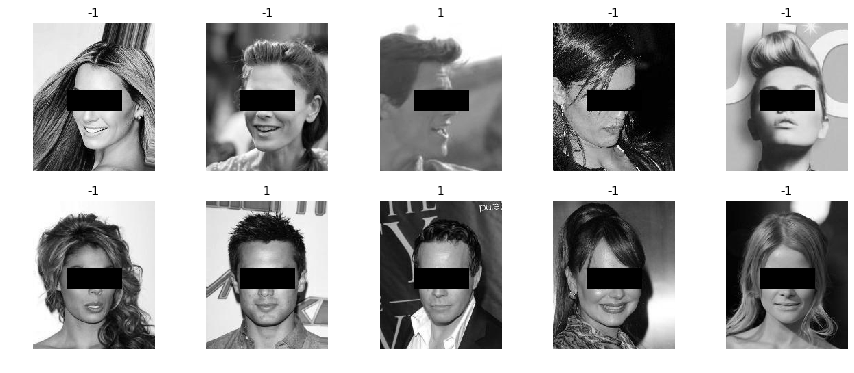

In [0]:
#let us display a few faces/gender
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image_without_eyes(path_to_img, img_index)
        gender = data_gender[img_index]
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.title(gender)
        plt.axis('off')

# Assignment
Use a very basic logistic regression model for distinguishing male from female faces.
1. Because the dataset is a little bit large, you will **never** attempt to load all it in RAM memory (even if you could if your hardware is relatively recent). This situation is very common in practice. If you load all the data in memory, your mark will be **zero** since the whole point of the assignment is to learn how to implement stochastic gradient descent without loading all the data in memory.
2. Use a very basic model: a standard logistic regression without intercept and without regularization.
3. You will use the first 190K images for training your model. The images that you have not used to train your model will be used to estimate the accuracy of the model.
4. You will describe **in words**, as accurately as possible, your approach (what algorithm, mini_batch size, momentum if this is used, etc...). In other words, you should produce a report, not just a bunch of code without comment. Clarity of the code and exposition will be taken into account in your final mark. For fitting the logistic regression model, you are allowed to use any method you would like. In other words, if you would like to use something more fancy than the stochastic gradient method (eg. Gauss-Newton approach, etc...) that has been describe during the lectures, you are indeed allowed to do so.
5. You will create plots summarizing the accuracy and the value of the loss function as the model is being trained. In other words, you will need to create plots of accuracy v.s. iteration index, and loss function v.s. iteration index.
6. You will report the accuracy of your model on the test set.
7. Report how long it takes for your algorithm to go through one epoch.
8. Call "beta" the parameter of the logistic regression: display the final "beta" you have found as an image.
9. Carry the same work but for images with eyes hidden. What is the drop in accuracy? What the the final "beta" in this case?
10. Your assignment report will be a jupyter notebook that I should be able to run myself.

#### Note: All the assignments will be made public on the IVLE system.
#### Note: This is a group assignment and communication between the groups is not allowed. If you have questions, post them on slack. Plagiarism is taken very seriously at NUS: http://www.nus.edu.sg/celc/programmes/plagiarism.html

### Advice:
1. Do as many sanity checks as possible
2. Experiments with the learning rates / momentum / schedule for reducing the learning rate / etc...
3. The algorithms will take time to run. It is often a good idea to save the results in files (e.g: save the trajectories of loss function value / accuracy / value of beta at the end of each epoch / etc...). Otherwise, it is very easy to lose 1 hour of computation doing a silly mistake.
4. For your initial beta, it is a good idea to take a random vector whose coordinates are random numbers with mean zero and variance 1 / dimension_of_covariates.  
For example:
> dim = dim_x * dim_y  
> beta_init = np.random.normal(loc = 0, scale = 1. / np.sqrt(dim), size = dim)
5. You do not have to monitor the loss function at each and every single mini-batch (this would take a lot of time)
6. it is ok to monitor the accuracy on a smaller subset of the training data.





In [0]:
train_img_index = np.arange(190000)
test_img_index = np.arange(190000, total_img)

### Functions that may reveal useful:

In [0]:
def build_covariates(path, image_index_array):
    """
    INPUT:
     path: path to the images
     image_index_array: an array of image indexes
    OUTPUT:
     an array of dimension (len(image_index_array)) x (38804).
     Each row is a flattened version of the corresponding image.
    """
    #BLABLABLABLA
    return covariates

def loss(beta, covariates, data):
    """
    INPUT:
     beta: parameter of the logistic regression
     covariates: an array of dimension (minibatch_size) x (38804)
     data: array of dimension (minibatch) containing the gender of each covariate
    OUPUT:
     the loss function when evaluated on the covariates contained in the array "covariates"
    """
    #BLABLABLABLA
    return ...

#gradient of the loss function with respect to "beta", the first argument of the function "loss"
grad_loss = grad(loss, argnum=0)


#Answer to assignment 1
**Remark:** It is assumed that no code is run before this line.  
##1. Downloading Data
Google Colab is used as the environment to run the Python notebook. The attribute txt file is modified and uploaded to the runtime environment, whereas the following script is used to download the photo data. 

Both the file and folder resides in the same directory as this Python notebook.

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='0B7EVK8r0v71pZjFTYXZWM3FlRnM',
                                    dest_path='./data.zip',
                                    unzip=True)
# check that data is downloaded by printing file count
import os

path, dirs, files = next(os.walk("./img_align_celeba"))
file_count = len(files)
print(file_count)

Unzipping...Done.
202599


Then we proceed to load all the photo's file names, using the code provided.

In [0]:
import os as os
import pandas as pd  

#read the filenames of all the images

path_to_img = "./img_align_celeba"
jpgfiles = [file for file in os.listdir(path_to_img) if os.path.isfile(os.path.join(path_to_img, file))]
total_img = len(jpgfiles)
print("Number of images = ", total_img)

#load all the attributes
data_frame = pd.read_csv('./list_attr_celeba.txt', delim_whitespace=True)
data_gender = data_frame.Male.values
print("Number of attributes loaded = ", len(data_gender))

Number of images =  202599
Number of attributes loaded =  202599


Next, we partition the photos into 2 sets, namely training set and validation set. 

The training set will be of size 190000, using photo of index 0 to 189999. Validation set will use the rest of the photos.

In [0]:
import autograd.numpy as np
from autograd import grad
np.random.seed(123)
TOTAL_SIZE = total_img
TRAINING_SIZE = 190*1000
TRAINING_SET_INDEXES = np.arange(TRAINING_SIZE)
VALIDATION_SET_INDEXES = np.arange(TRAINING_SIZE, total_img)
# check whether they ends at the correct indexes respectively
print(TRAINING_SET_INDEXES[0])
print(TRAINING_SET_INDEXES[-1])
print(VALIDATION_SET_INDEXES[0])
print(VALIDATION_SET_INDEXES[-1])



0
189999
190000
202598


##2. Auxillary Functions for Training

We implement the `build_covariates` function, so that we can form an array of flattened image vector, whose length equals the input array's length.

In [0]:
# This is the given code to read an image
from PIL import Image  

def read_image(path, file_index):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, jpgfiles[file_index])))
    return np.mean(img, axis=2) / 255.
# End of given code
IMAGE_VECTOR_SIZE = 38804
def build_covariates(path, image_index_array):
    """
    INPUT:
     path: path to the images
     image_index_array: an array of image indexes
    OUTPUT:
     an array of dimension (len(image_index_array)) x (38804).
     Each row is a flattened version of the corresponding image.
    """
    initial_dimension = (len(image_index_array), IMAGE_VECTOR_SIZE)
    ret = np.empty(initial_dimension)
    for i in range(0,len(image_index_array)):
        img = read_image(path, image_index_array[i])
        vectorised_img = img.flatten()
        np_img = np.array(vectorised_img)
        ret[i] = np_img
    return ret
  
 # perform a sanity check on build_covariates
first_3_vectorised_images = build_covariates('./img_align_celeba', [0,1,2])
print(first_3_vectorised_images)
print(first_3_vectorised_images.shape)

[[0.50718954 0.49542484 0.47843137 ... 0.96862745 0.97385621 0.97385621]
 [0.01568627 0.01568627 0.01568627 ... 0.92941176 0.94117647 0.94117647]
 [0.1124183  0.1124183  0.10849673 ... 0.0130719  0.00392157 0.00392157]]
(3, 38804)


Also, since we cannot load to memory all the photos, we load the 190000 photos 1900 times, and we only load into memory, using `build_covariates` function, 100 photos at a time.

Here we provide a function that can generate the randomised 1900 arrays of dimension 100, so that each epoch will have different training sequence.

We now define a function that generates a random arrangement of the numbers from 1 to 190000, and partition the numbers in 100 groups.  This will allow us to shuffle the training dataset.

In [0]:
def generate_random_permutation_2d(totalSize,batchSize):
    # randomly selects all from 0 to totalSize - 1
    order = np.random.choice(totalSize, totalSize, replace=False)
    # and shape into (totalSize/batchSize) x batchSize
    return order.reshape(int(totalSize/batchSize),batchSize)
MINIBATCH_SIZE = 100
permutation = generate_random_permutation_2d(TRAINING_SIZE, MINIBATCH_SIZE)

# sanity check on dimension
print(permutation.shape)
# and also randomness
print(permutation)

(1900, 100)
[[170024  40422 181585 ... 127255 167571  75501]
 [123304 183092  91274 ...  97787 180282  94941]
 [ 21696 172786  50862 ... 178275  44825 105474]
 ...
 [ 21366  38739 151029 ... 146391   9528  59824]
 [183798  60347 185685 ...  51054  12221  40337]
 [ 76582  35355  39052 ...  17730  28030  15725]]


Next, we proceed onto `loss` that computes the loss.

In [0]:
def loss(beta, covariates, data):
    """
    INPUT:
     beta: parameter of the logistic regression
     covariates: an array of dimension (minibatch_size) x (38804)
     data: array of dimension (minibatch) containing the gender of each covariate
    OUPUT:
     the loss function when evaluated on the covariates contained in the array "covariates"
    """
    dot_product = np.dot(covariates, beta)
    return np.sum(np.log(1. + np.exp(-data*dot_product)))

# sanity check using the first minibatch
cov_minibatch_1 = build_covariates(path_to_img, permutation[0])
print(cov_minibatch_1.shape)
initial_beta = np.random.normal(loc = 0, scale = 1. / np.sqrt(IMAGE_VECTOR_SIZE), size = IMAGE_VECTOR_SIZE)
print(initial_beta)
print(initial_beta.shape)
initial_loss = loss(initial_beta, cov_minibatch_1, data_gender[permutation[0]])
print(initial_loss)

def init_beta_random(): 
  return np.random.normal(loc = 0, scale = 1. / np.sqrt(IMAGE_VECTOR_SIZE), size = IMAGE_VECTOR_SIZE)

(100, 38804)
[ 0.00022781  0.00303317  0.00314573 ... -0.00691504  0.00166281
 -0.00670986]
(38804,)
70.3200103180354


Last but not the least, we need to implement `accuracy`.

In [0]:
def probabilistic_predictions(beta, covariates):
    # this is a Sigmoid
    dot_products = np.dot(covariates, beta)
    proba_vector = 1. / (1. + np.exp(-dot_products))
    return proba_vector


def predictions(beta, covariates):
    # a perceptron to binarise sigmoid output
    proba_vector = probabilistic_predictions(beta,covariates)
    nb_of_examples = covariates.shape[0]
    predictions = np.zeros(nb_of_examples)
    predictions[proba_vector>=0.5] = 1
    predictions[proba_vector<0.5] = -1
    return predictions

def accuracy(beta, covariates, true_labels):
    # compute prob
    prediction_list = predictions(beta, covariates)
    return np.mean(prediction_list == true_labels)
  
print(probabilistic_predictions(initial_beta, cov_minibatch_1))
print(accuracy(initial_beta, cov_minibatch_1, data_gender[permutation[0]]))

[0.47418276 0.55997498 0.55423878 0.42530255 0.58740277 0.48908621
 0.58155226 0.53917704 0.51990738 0.49238127 0.66695009 0.6784571
 0.499538   0.57656755 0.58137061 0.61675272 0.60936649 0.51778346
 0.47562581 0.52811896 0.53057843 0.64970953 0.48454431 0.4961806
 0.47674568 0.53411705 0.49057415 0.53624321 0.57839886 0.4502944
 0.67679951 0.59785074 0.50522502 0.64049134 0.44034731 0.43350432
 0.60610457 0.6738628  0.52366678 0.48802791 0.57769932 0.55560952
 0.44323478 0.60758539 0.54492389 0.54193454 0.58912857 0.54968513
 0.5420612  0.57173734 0.55438942 0.56261461 0.55402607 0.57425458
 0.56265855 0.4698589  0.62875008 0.5930898  0.65427549 0.58358333
 0.5176582  0.59430373 0.55400079 0.52330519 0.5848379  0.48940156
 0.52353696 0.455451   0.47892473 0.5156482  0.41367695 0.43868904
 0.52920656 0.47213753 0.47803484 0.553601   0.49130248 0.57714826
 0.5344558  0.44950158 0.50229201 0.58439331 0.45293332 0.47280066
 0.66121843 0.46733857 0.36765309 0.48272524 0.61671839 0.5392098

#3. Training
We are all good to go. Now we implement the stochastic gradient descent algorithm.
We first experiment to check which learning rate seems promising.


In [0]:
from tqdm import tqdm
import time as time 
grad_loss = grad(loss, argnum=0)

test_data = build_covariates(path_to_img, VALIDATION_SET_INDEXES)
test_data_label_val = data_gender[VALIDATION_SET_INDEXES]



######################################################################################################
betas = [init_beta_random(), init_beta_random()]
#gradient
#Set learning rate
learning_rates = [0.0000002, 0.0000001,0.00000005]
nb_iteration = 200 # permutation.shape[0]
#Store 1) Loss function, 2) Accuracy, 3) Beta_history 
loss_function_history = np.zeros((len(learning_rates)*len(betas), nb_iteration))
accuracy_history = np.zeros((len(learning_rates)*len(betas), nb_iteration))
# beta_history = np.zeros((nb_iteration, 38804))
# time_history = np.zeros(nb_iteration)
#Start time
for j in range(len(betas)):
  for i in range(len(learning_rates)):
    beta = betas[j]
    learning_rate = learning_rates[i]
    start = time.time()
    for k in tqdm(range(nb_iteration)):
        mini_batch_array= permutation[k]
        mini_batch = build_covariates(path_to_img, mini_batch_array)
        gradient = grad_loss(beta, mini_batch, data_gender[mini_batch_array])
        beta = beta - learning_rate * gradient
        accuracy_history[len(learning_rates)*j+i][k] = accuracy(beta, test_data, test_data_label_val)
        loss_function_history[len(learning_rates)*j+i][k] = loss(beta, mini_batch, data_gender[mini_batch_array])
        # learning_rate = learning_rate*0.98
        #beta_history[k,:] = np.copy(beta)
        #time_history[k] = time.time()-start
    end = time.time()



100%|██████████| 200/200 [02:02<00:00,  1.54it/s]


In [0]:
chosen_beta = betas[1]
chosen_learning_rate = learning_rates[2]
nb_iteration = permutation.shape[0]
loss_function_history = np.zeros(nb_iteration)
accuracy_history = np.zeros(nb_iteration)
beta_history = np.zeros((nb_iteration, 38804))
time_history = np.zeros(nb_iteration)
#Start time

start = time.time()
for k in tqdm(range(nb_iteration)):
    mini_batch_array= permutation[k]
    mini_batch = build_covariates(path_to_img, mini_batch_array)
    gradient = grad_loss(chosen_beta, mini_batch, data_gender[mini_batch_array])
    chosen_beta = chosen_beta - chosen_learning_rate * gradient
    accuracy_history[k] = accuracy(chosen_beta, test_data, test_data_label_val)
    loss_function_history[k] = loss(chosen_beta, mini_batch, data_gender[mini_batch_array])
    beta_history[k,:] = np.copy(chosen_beta)
    time_history[k] = time.time()-start



100%|██████████| 1900/1900 [21:03<00:00,  1.56it/s]


In [0]:
print(chosen_beta[0:])

[-0.00069388  0.00379844 -0.00381468 ...  0.00920003  0.00189182
 -0.00070689]


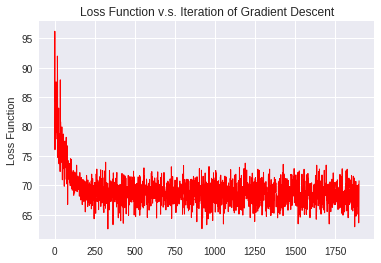

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(loss_function_history , "r-", lw=1)
plt.title("Loss Function v.s. Iteration of Gradient Descent")
plt.ylabel("Loss Function")
plt.grid(True)

In [0]:
print(accuracy(chosen_beta, test_data, test_data_label_val))

0.6033018493531233


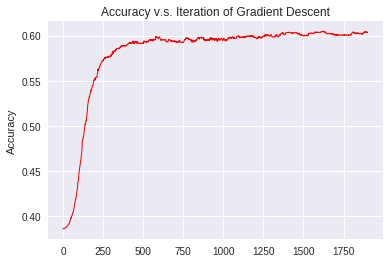

In [0]:

plt.plot(accuracy_history , "r-", lw=1)
plt.title("Accuracy v.s. Iteration of Gradient Descent")
plt.ylabel("Accuracy")
plt.grid(True)

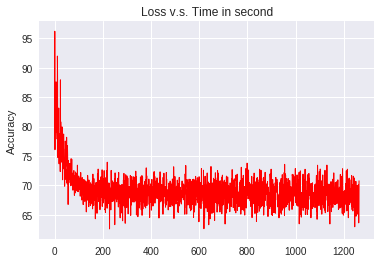

In [0]:
plt.plot(time_history, loss_function_history , "r-", lw=1)
plt.title("Loss v.s. Time in second")
plt.ylabel("Accuracy")
plt.grid(True)

Next, we explore with eyes hidden.

Training...

In [0]:
# clear unused arrays
%xdel beta_history

In [0]:


def read_image_without_eyes(path, file_index):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, jpgfiles[file_index])))
    img_black_n_white = np.mean(img, axis=2) / 255.
    img_black_n_white[100:130,50:130] = 0
    return img_black_n_white
  

def build_covariates_without_eyes(path, image_index_array):
    """
    INPUT:
     path: path to the images
     image_index_array: an array of image indexes
    OUTPUT:
     an array of dimension (len(image_index_array)) x (38804).
     Each row is a flattened version of the corresponding image.
    """
    initial_dimension = (len(image_index_array), IMAGE_VECTOR_SIZE)
    ret = np.empty(initial_dimension)
    for i in range(0,len(image_index_array)):
        img = read_image_without_eyes(path, image_index_array[i])
        vectorised_img = img.flatten()
        np_img = np.array(vectorised_img)
        ret[i] = np_img
    return ret

test_data_without_eyes = build_covariates_without_eyes(path_to_img, VALIDATION_SET_INDEXES)
beta_without_eyes = betas[1]

#gradient
#Set learning rate
learning_rate = learning_rates[2]
nb_iteration = permutation.shape[0]
#Store 1) Loss function, 2) Accuracy, 3) Beta_history 
loss_function_history_without_eyes = np.zeros(nb_iteration)
accuracy_history_without_eyes = np.zeros(nb_iteration)
# beta_history_without_eyes = np.zeros((nb_iteration, 38804))
time_history_without_eyes = np.zeros(nb_iteration)

#Start time
start = time.time()
for k in tqdm(range(nb_iteration)):
    #Obtain indexes for minibatch
    mini_batch_array= permutation[k]
    #Extract mini-batch
    mini_batch = build_covariates_without_eyes(path_to_img, mini_batch_array)
    #Compute gradient and apply gradient descent update
    gradient = grad_loss(beta_without_eyes, mini_batch, data_gender[mini_batch_array])
    beta_without_eyes = beta_without_eyes - learning_rate * gradient
    accuracy_history_without_eyes[k] = accuracy(beta_without_eyes, test_data_without_eyes, test_data_label_val)
    loss_function_history_without_eyes[k] = loss(beta_without_eyes, mini_batch, data_gender[mini_batch_array])
    # beta_history_without_eyes[k,:] = np.copy(beta_without_eyes)
    time_history_without_eyes[k] = time.time()-start
#end time
end = time.time()
#Compute Time taken


100%|██████████| 1900/1900 [21:58<00:00,  1.54it/s]


And plotting.

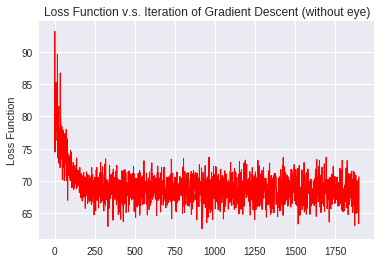

In [0]:
plt.plot(loss_function_history_without_eyes , "r-", lw=1)
plt.title("Loss Function v.s. Iteration of Gradient Descent (without eye)")
plt.ylabel("Loss Function")
plt.grid(True)

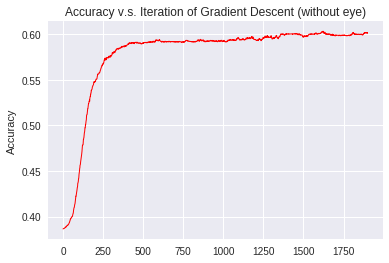

In [0]:
plt.plot(accuracy_history_without_eyes , "r-", lw=1)
plt.title("Accuracy v.s. Iteration of Gradient Descent (without eye)")
plt.ylabel("Accuracy")
plt.grid(True)

In [0]:
print(accuracy(beta_without_eyes, test_data_without_eyes, test_data_label_val))

0.6010000793713787


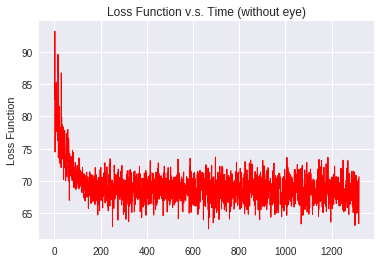

In [0]:
plt.plot(time_history_without_eyes, loss_function_history_without_eyes , "r-", lw=1)
plt.title("Loss Function v.s. Time (without eye)")
plt.ylabel("Loss Function")
plt.grid(True)

As one can see, we have a slight accuracy drop(0.002) if we train without eyes.

In [0]:
print(accuracy(chosen_beta, test_data, test_data_label_val) - accuracy(beta_without_eyes, test_data_without_eyes, test_data_label_val))

0.0023017699817445836
